In [3]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3
    !pip install install torch-summary

In [5]:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3
    !pip install install torch-summary

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.5 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires tensorboard~=2.6, but you have tensorboard 2.3.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.7.1 which is incompatible.


In [6]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque, defaultdict
from itertools import count
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from torchvision.transforms import Resize, InterpolationMode
from torchsummary import summary

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    from IPython.display import clear_output

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.capacity = capacity

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
#based on:
#https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/rl/dqn/replay_buffer.py

class ReplayBuffer(object):
    '''
    https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/rl/dqn/replay_buffer.py
    '''

    def __init__(self, capacity, alpha):
        """
        ### Initialize
        """
        # We use a power of $2$ for capacity because it simplifies the code and debugging
        self.capacity = capacity
        # $\alpha$
        self.alpha = alpha

        # Maintain segment binary trees to take sum and find minimum over a range
        self.priority_sum = [0 for _ in range(2 * self.capacity)]
        self.priority_min = [float('inf') for _ in range(2 * self.capacity)]

        # Current max priority, $p$, to be assigned to new transitions
        self.max_priority = 1.

        # Arrays for buffer
        self.data = {
            'obs': np.zeros(shape=(capacity, 4, 84, 84), dtype=np.uint8),
            'action': np.zeros(shape=capacity, dtype=np.int32),
            'reward': np.zeros(shape=capacity, dtype=np.float32),
            'next_obs': np.zeros(shape=(capacity, 4, 84, 84), dtype=np.uint8),
            'done': np.zeros(shape=capacity, dtype=np.bool)
        }
        # We use cyclic buffers to store data, and `next_idx` keeps the index of the next empty
        # slot
        self.next_idx = 0

        # Size of the buffer
        self.size = 0

    def push(self, obs, action, reward, next_obs, done):
        """
        ### Add sample to queue
        """

        # Get next available slot
        idx = self.next_idx

        # store in the queue
        self.data['obs'][idx] = obs
        self.data['action'][idx] = action
        self.data['reward'][idx] = reward
        self.data['next_obs'][idx] = next_obs
        self.data['done'][idx] = done

        # Increment next available slot
        self.next_idx = (idx + 1) % self.capacity
        # Calculate the size
        self.size = min(self.capacity, self.size + 1)

        # $p_i^\alpha$, new samples get `max_priority`
        priority_alpha = self.max_priority ** self.alpha
        # Update the two segment trees for sum and minimum
        self._set_priority_min(idx, priority_alpha)
        self._set_priority_sum(idx, priority_alpha)

    def _set_priority_min(self, idx, priority_alpha):
        """
        #### Set priority in binary segment tree for minimum
        """

        # Leaf of the binary tree
        idx += self.capacity
        self.priority_min[idx] = priority_alpha

        # Update tree, by traversing along ancestors.
        # Continue until the root of the tree.
        while idx >= 2:
            # Get the index of the parent node
            idx //= 2
            # Value of the parent node is the minimum of it's two children
            self.priority_min[idx] = min(self.priority_min[2 * idx], self.priority_min[2 * idx + 1])

    def _set_priority_sum(self, idx, priority):
        """
        #### Set priority in binary segment tree for sum
        """

        # Leaf of the binary tree
        idx += self.capacity
        # Set the priority at the leaf
        self.priority_sum[idx] = priority

        # Update tree, by traversing along ancestors.
        # Continue until the root of the tree.
        while idx >= 2:
            # Get the index of the parent node
            idx //= 2
            # Value of the parent node is the sum of it's two children
            self.priority_sum[idx] = self.priority_sum[2 * idx] + self.priority_sum[2 * idx + 1]

    def _sum(self):
        """
        #### $\sum_k p_k^\alpha$
        """

        # The root node keeps the sum of all values
        return self.priority_sum[1]

    def _min(self):
        """
        #### $\min_k p_k^\alpha$
        """

        # The root node keeps the minimum of all values
        return self.priority_min[1]

    def find_prefix_sum_idx(self, prefix_sum):
        """
        #### Find largest $i$ such that $\sum_{k=1}^{i} p_k^\alpha  \le P$
        """

        # Start from the root
        idx = 1
        while idx < self.capacity:
            # If the sum of the left branch is higher than required sum
            if self.priority_sum[idx * 2] > prefix_sum:
                # Go to left branch of the tree
                idx = 2 * idx
            else:
                # Otherwise go to right branch and reduce the sum of left
                #  branch from required sum
                prefix_sum -= self.priority_sum[idx * 2]
                idx = 2 * idx + 1

        # We are at the leaf node. Subtract the capacity by the index in the tree
        # to get the index of actual value
        return idx - self.capacity

    def sample(self, batch_size, beta):
        """
        ### Sample from buffer
        """

        # Initialize samples
        samples = {
            'weights': np.zeros(shape=batch_size, dtype=np.float32),
            'indexes': np.zeros(shape=batch_size, dtype=np.int32)
        }

        # Get sample indexes
        for i in range(batch_size):
            p = random.random() * self._sum()
            idx = self.find_prefix_sum_idx(p)
            samples['indexes'][i] = idx

        # $\min_i P(i) = \frac{\min_i p_i^\alpha}{\sum_k p_k^\alpha}$
        prob_min = self._min() / self._sum()
        # $\max_i w_i = \bigg(\frac{1}{N} \frac{1}{\min_i P(i)}\bigg)^\beta$
        max_weight = (prob_min * self.size) ** (-beta)

        for i in range(batch_size):
            idx = samples['indexes'][i]
            # $P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}$
            prob = self.priority_sum[idx + self.capacity] / self._sum()
            # $w_i = \bigg(\frac{1}{N} \frac{1}{P(i)}\bigg)^\beta$
            weight = (prob * self.size) ** (-beta)
            # Normalize by $\frac{1}{\max_i w_i}$,
            #  which also cancels off the $\frac{1}{N}$ term
            samples['weights'][i] = weight / max_weight

        # Get samples data
        for k, v in self.data.items():
            samples[k] = v[samples['indexes']]

        return samples

    def update_priorities(self, indexes, priorities):
        """
        ### Update priorities
        """

        for idx, priority in zip(indexes, priorities):
            # Set current max priority
            self.max_priority = max(self.max_priority, priority)

            # Calculate $p_i^\alpha$
            priority_alpha = priority ** self.alpha
            # Update the trees
            self._set_priority_min(idx, priority_alpha)
            self._set_priority_sum(idx, priority_alpha)

    def is_full(self):
        """
        ### Whether the buffer is full
        """
        return self.capacity == self.size

In [20]:
class DQN(nn.Module):

    def __init__(self,
                 #n_observations: int,
                 n_actions: int,
                 #n_layers: int,
                 base_width = 16,
                 activation = nn.ReLU,
                 norm = nn.BatchNorm2d,
        ):
        super(DQN, self).__init__()
        self.activation = activation()
        self.conv1 = nn.Conv2d(3,base_width, kernel_size = 7, bias = False)
        self.norm1 = norm(base_width)
        self.conv2 = nn.Conv2d(base_width, base_width*2, kernel_size = 5, bias = False)
        self.norm2 = norm(base_width*2)
        self.conv3 = nn.Conv2d(base_width*2, base_width*4, kernel_size = 5, bias = False)
        self.norm3 = norm(base_width*4)

        self.max_pool = nn.MaxPool2d(2, stride=2)
        self.aggregate = nn.AdaptiveMaxPool2d(1)
        self.linear1 = nn.Linear(base_width*4, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self,
                x # shape: [N, C, H, W]
                ):
        x = self.conv1(x)
        #x = self.max_pool(x)
        x = self.activation(self.norm1(x))
        x = self.conv2(x)
        #x = self.max_pool(x)
        x = self.activation(self.norm2(x))
        x = self.conv3(x)
        x = self.max_pool(x)
        x = self.activation(self.norm3(x))
        x = self.aggregate(x).squeeze(2).squeeze(2)
        return self.linear1(x)

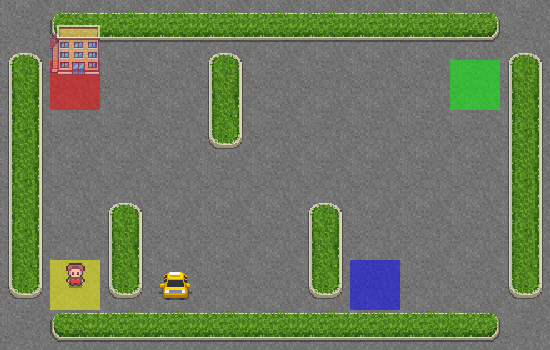

In [21]:
env = gym.make("Taxi-v3", render_mode = "rgb_array")
env.reset()
env.step(0)
state = env.render()
img = Image.fromarray(state, "RGB")
img.show()

In [22]:
downscale = Resize(size = (30, 40), interpolation = InterpolationMode.NEAREST)
state_ = downscale(torch.Tensor(state).permute(2,0,1))
state_.shape

torch.Size([3, 30, 40])

In [23]:
from PIL import Image
img = Image.fromarray(state_.permute(1,2,0).detach().numpy().astype(np.uint8), "RGB")
img.show()

In [24]:
#
class DecayVal:
    val: float
    decay: float
    schedule: int
    def __init__(self, val, decay, schedule):
        self.val = val
        self.decay = decay
        self.i = 0
        self.schedule = schedule

    def __call__(self):
        return self.val

    def step(self):
        self.i += 1
        if self.i % self.schedule == 0:
            self.val *= self.decay

In [25]:
class Agent_NN:
    def __init__(
            self,
            model_class,
           # states_size: int,
            actions_size: int,
            replay_buffer: ReplayMemory,
            batch_size : int = 128,
            gamma: float = 0.99,
            eps: float= 0.5,
            tau: int = 0.01,
            lr: float = 0.05,
            seed: int = 42,
            device: str = "cpu",
    ) -> None:
        Q_policy = model_class(actions_size).to(device)
        Q_target = model_class(actions_size).to(device)
        Q_target.load_state_dict(Q_policy.state_dict())
        self.Q_policy = Q_policy
        self.Q_target = Q_target
        self.replay_buffer = replay_buffer

        self.criterion = nn.SmoothL1Loss()
        self.optimizer = AdamW(self.Q_policy.parameters(), lr=lr, amsgrad=True)

        self.gamma = gamma
        self.eps = eps
        self.tau = tau
        self.lr = lr
        self.batch_size = batch_size

        self.rng = np.random.default_rng(seed)
        self.actions_size = actions_size
        self.device = device

    def policy(self, state):
        if self.rng.random() < self.eps():
            action = torch.randint(0, self.actions_size, (1,1)).to(self.device)
        else:
            action = self.Q_policy(state).argmax(1).unsqueeze(0)
        return action

    def reset(self):
        self.eps.step()

    def update_policy(self):
        if len(self.replay_buffer) < self.batch_size:
            return None
        transitions = self.replay_buffer.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net

        #print(action_batch, self.Q_policy(state_batch))
        state_action_values = self.Q_policy(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.Q_target(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        with torch.enable_grad():
            loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.Q_policy.parameters(), 100)
        self.optimizer.step()

        return loss.clone().item()

    def update_target(self):
        target_net_state_dict = self.Q_target.state_dict()
        policy_net_state_dict = self.Q_policy.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
        self.Q_target.load_state_dict(target_net_state_dict)

In [26]:
class Trainer:

    def __init__(self,
                 environment,
                 agent,
                 name = "SPECIFY EXPERIMENT NAME",
                 seed: int = 42,
                 reduction_size = (50, 70),
                 device = "cpu"):
        self.name = name
        self.device = device
        self.env = environment
        self.agent = agent
        self.downscale = Resize(size = reduction_size, interpolation = InterpolationMode.NEAREST)
        self.rng = np.random.default_rng(seed)

    def get_agent(self):
        return self.agent

    def show_progress(self,**stats):

        """
        Удобная функция, которая отображает прогресс обучения.
        """
        clear_output(True)
        fig, ax = plt.subplots(2,2, figsize=[14, 6])
        fig.suptitle(self.name)
        ax[0, 0].plot(*zip(*stats["avg_returns"]))
        ax[0, 0].set_title('Mean return')
        ax[0, 0].grid()

        ax[0, 1].plot(*zip(*stats["lifetime_errors"]))
        ax[0, 1].set_title('TD errors')
        ax[0, 1].grid()

        ax[1, 0].plot(*zip(*stats["success_rate"]))
        ax[1, 0].set_title('Success rate')
        ax[1, 0].grid()

        ax[1, 1].plot(*zip(*stats["trajectory_lengths"]))
        ax[1, 1].set_title('Trajectory lengths')
        ax[1, 1].grid()

        plt.show()

    def train(self,
              num_episodes = 2000,
              success_rate_window = 20,
              show_progress_schedule = 1):

        memory_device = self.device

        lifetime_errors = []
        success_rate, success_batch = [], []
        trajectory_lengths = []
        experience = defaultdict(list)
        avg_returns, returns_batch = [], []

        for i in range(num_episodes):
            episodic_error = []
            state_ind, _ = self.env.reset()
            state = torch.tensor(self.env.render()/256).permute(2,0,1).float().unsqueeze(0).to(self.device)
            state = self.downscale(state)

            reward, episode_return = 0, 0
            time = 0
            while True:

                action = self.agent.policy(state)
                next_state_ind, reward, terminated, truncated, misc = self.env.step(action.item())
                reward = torch.tensor([reward]).float().to(self.device)
                next_state = torch.tensor(self.env.render()/256).permute(2,0,1).float().unsqueeze(0).to(self.device)
                next_state = self.downscale(next_state)
                done = terminated or truncated

                if terminated:
                    next_state = None
                else:
                    next_state = next_state

                point = dict(
                    state = state,
                    action = action,
                    reward = reward,
                    next_state = next_state,
                    misc = misc)
                experience[i].append(point)

                agent.replay_buffer.push(state,
                                         action,
                                         reward,
                                         next_state,
                                         done)

                error = self.agent.update_policy()
                time += 1
                if error != None:
                    episodic_error.append(error)
                else:
                    clear_output(True)
                    print(f"Collecting memories {len(agent.replay_buffer)}/{agent.batch_size}")
                    print(f"Stats: state index {state_ind}, action {action}, reward {reward}, next state index {next_state_ind}")
                    print(f"Episode {i}: step {time}")
                state = next_state
                episode_return += reward

                agent.update_target()

                if done:
                    self.agent.reset()
                    break

            returns_batch.append(episode_return.cpu().detach().numpy())
            trajectory_lengths.append((i,time))

            success_batch.append(terminated)
            if len(success_batch) == success_rate_window:
                success_rate.append((i, np.mean(success_batch)))
                success_batch = []

            lifetime_errors.append((i, np.mean(episodic_error)))

            if i % show_progress_schedule == 0:
                avg_returns.append((i, np.mean(returns_batch)))
                returns_batch = []

                self.show_progress(
                    avg_returns = avg_returns,
                    lifetime_errors = lifetime_errors,
                    success_rate = success_rate,
                    trajectory_lengths = trajectory_lengths,
                )
                print(
                    f"Episode: {i}, Return: {episode_return}, "
                    f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
                )

        return {
            "lifetime_errors" : lifetime_errors,
            "success_rate": success_rate,
            "trajectory_lengths": trajectory_lengths,
            "experience": experience,
            "avg_returns": avg_returns,
        }


In [27]:
env = gym.make("Taxi-v3", render_mode = "rgb_array")
env.reset(seed = 42)

agent = Agent_NN(
    model_class = DQN,
    actions_size = env.action_space.n,
    replay_buffer= ReplayMemory(2000),
    eps = DecayVal(val=0.3, decay=0.7, schedule=100),
    device = device,
    batch_size = 256,
    gamma = 0.99,
    tau= 0.01,
    lr= 0.01,
    seed = 42,
    )

trainer = Trainer(
    agent = agent,
    environment = env,
    name = "DQN",
    device = device,
    reduction_size = (30, 40)
)

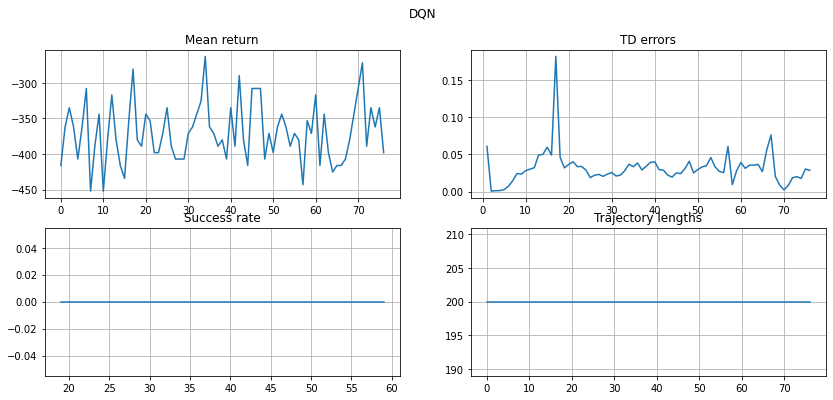

Episode: 76, Return: tensor([-398.], device='cuda:0'), AvgReturn[1]: -398


KeyboardInterrupt: 

In [28]:
trainer.train(num_episodes=1000)